<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-idea" data-toc-modified-id="The-idea-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The idea</a></span></li><li><span><a href="#A-baseline-model" data-toc-modified-id="A-baseline-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>A baseline model</a></span></li><li><span><a href="#Test-set" data-toc-modified-id="Test-set-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Test set</a></span></li><li><span><a href="#Longer" data-toc-modified-id="Longer-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Longer</a></span></li><li><span><a href="#Explainability" data-toc-modified-id="Explainability-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Explainability</a></span><ul class="toc-item"><li><span><a href="#Permutation-importance" data-toc-modified-id="Permutation-importance-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Permutation importance</a></span></li><li><span><a href="#Partial-plots" data-toc-modified-id="Partial-plots-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Partial plots</a></span></li><li><span><a href="#Shap-Values" data-toc-modified-id="Shap-Values-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Shap Values</a></span></li></ul></li></ul></div>

# The idea

We forget for the moment the Physics, we start from the raw data and we try to get a model as good as possible.

In [1]:
import pandas as pd


df = pd.read_csv("../input/train.csv")
df.head()

,N,Z,BE
0,0,1,0.00000
1,1,1,1.11228
2,2,1,2.82726
3,1,2,2.57268
4,3,1,1.72044


By construction, there are no missing data. As a first step, I plot the response ``BE`` against the input (``N`` and ``Z``). 

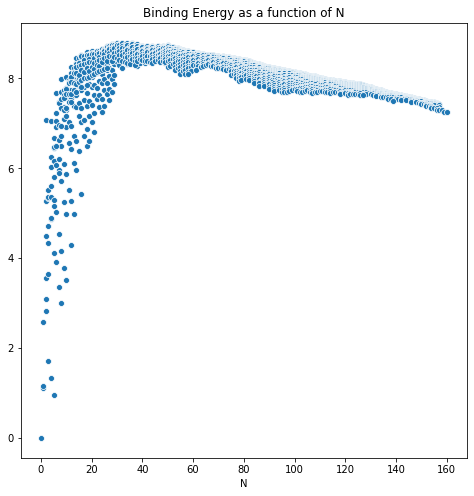

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure(figsize=(8, 8))
sns.scatterplot(df["N"], df["BE"])
plt.title("Binding Energy as a function of N")
plt.xlabel("N")
plt.ylabel("")
plt.savefig("Exploration_N.png", dpi=600, bbox_inches="tight")

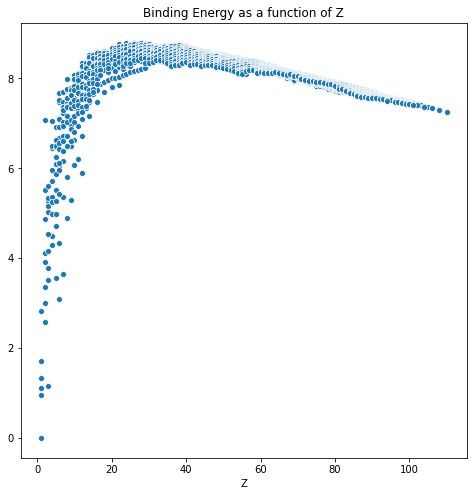

In [3]:
plt.figure(figsize=(8, 8))
sns.scatterplot(df["Z"], df["BE"])
plt.title("Binding Energy as a function of Z")
plt.xlabel("Z")
plt.ylabel("")
plt.savefig("Exploration_Z.png", dpi=600, bbox_inches="tight")

# A baseline model

Using Keras, I permute the data order (otherwise the validation set will consider the last part of the data (heavy nuclei) with a biased error estimation.

In [4]:
import numpy as np


np.random.seed(2020)
perm = np.random.permutation(df)

X_tr = perm[:, 0:2]
Y_tr = perm[:, 2]

In [5]:
X_tr

array([[ 56.,  37.],
       [ 50.,  39.],
       [ 50.,  31.],
       ...,
       [130.,  84.],
       [ 35.,  24.],
       [ 57.,  48.]])

Fixing some parameters: number of epochs, batch size, input size:

In [6]:
nb_epoch = 10000
batch_size = 128
input_dim = 2

In [7]:
from keras.layers import Input
from keras.layers import Dense
from keras.models import Sequential


nn = Sequential()
nn.add(Dense(32, activation="relu", kernel_initializer="glorot_normal", input_dim=input_dim))
nn.add(Dense(16, activation="relu", kernel_initializer="glorot_normal"))
nn.add(Dense(32, activation="relu", kernel_initializer="glorot_normal"))
nn.add(Dense(4, activation="relu", kernel_initializer="glorot_normal"))
nn.add(Dense(1, activation="linear", kernel_initializer="glorot_normal"))

nn.compile(optimizer="adam", loss="mean_squared_error")
history = nn.fit(
    X_tr,
    Y_tr,
    epochs=nb_epoch,
    batch_size=batch_size,
    shuffle=True,
    verbose=0,
    validation_split=0.20,
).history

Using TensorFlow backend.
/home/marco/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/marco/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/marco/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/marco/.local/lib/python3.6/site-packages/tensorflow/python/fra

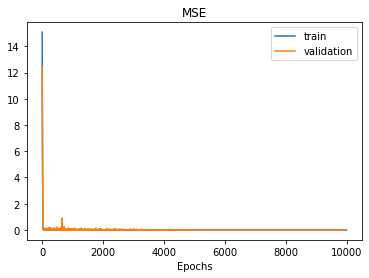

0.0012888466699503775
0.002005306571182743


In [8]:
train_loss = history["loss"]
val_loss = history["val_loss"]
t = np.linspace(1, len(train_loss), len(train_loss))

sns.lineplot(t, train_loss, label="train")
sns.lineplot(t, val_loss, label="validation")
plt.xlabel("Epochs")
plt.title("MSE")
plt.legend() 
plt.show()

print(train_loss[-1])
print(val_loss[-1])

In [9]:
nb_epoch = 10000

nn = Sequential()
nn.add(Dense(32, activation="relu", kernel_initializer="glorot_normal", input_dim=input_dim))
nn.add(Dense(16, activation="relu", kernel_initializer="glorot_normal"))
nn.add(Dense(32, activation="relu", kernel_initializer="glorot_normal"))
nn.add(Dense(8, activation="relu", kernel_initializer="glorot_normal"))
nn.add(Dense(4, activation="relu", kernel_initializer="glorot_normal"))
nn.add(Dense(1, activation="linear", kernel_initializer="glorot_normal"))

nn.compile(optimizer="adam", loss="mean_squared_error")
history = nn.fit(
    X_tr,
    Y_tr,
    epochs=nb_epoch,
    batch_size=batch_size,
    shuffle=True,
    verbose=0,
    validation_split=0.20,
).history

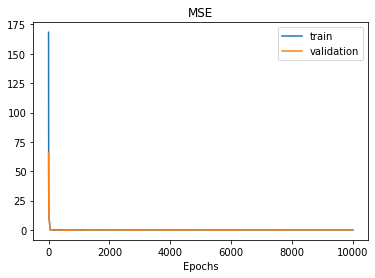

0.0031216700724457616
0.006533633641233129
0.055871907721553246
0.0808308953385593


In [10]:
train_loss = history["loss"]
val_loss = history["val_loss"]
t = np.linspace(1, len(train_loss), len(train_loss))

sns.lineplot(t, train_loss, label="train")
sns.lineplot(t, val_loss, label="validation")
plt.xlabel("Epochs")
plt.title("MSE")
plt.legend() 
plt.show()

print(train_loss[-1])
print(val_loss[-1])
print(np.sqrt(train_loss[-1]))
print(np.sqrt(val_loss[-1]))

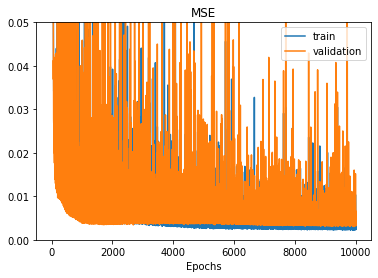

In [11]:
sns.lineplot(t, train_loss, label="train")
sns.lineplot(t, val_loss, label="validation")
plt.xlabel("Epochs")
plt.ylim(0, 0.05)
plt.title("MSE")
plt.legend() 
plt.show()

In [12]:
nb_epoch = 20000

nn = Sequential()
nn.add(Dense(32, activation="relu", kernel_initializer="glorot_normal", input_dim=input_dim))
nn.add(Dense(16, activation="relu", kernel_initializer="glorot_normal"))
nn.add(Dense(32, activation="relu", kernel_initializer="glorot_normal"))
nn.add(Dense(8, activation="relu", kernel_initializer="glorot_normal"))
nn.add(Dense(4, activation="relu", kernel_initializer="glorot_normal"))
nn.add(Dense(1, activation="linear", kernel_initializer="glorot_normal"))

nn.compile(optimizer="adam", loss="mean_squared_error")
history = nn.fit(
    X_tr,
    Y_tr,
    epochs=nb_epoch,
    batch_size=batch_size,
    shuffle=True,
    verbose=0,
    validation_split=0.20,
).history

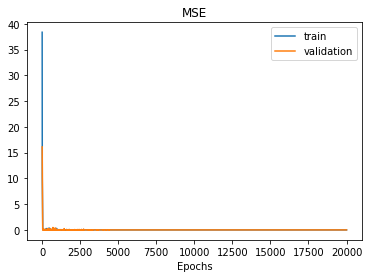

0.000683483445080443
0.0031967339922484676
0.02614351631055859
0.0565396674225138


In [13]:
train_loss = history["loss"]
val_loss = history["val_loss"]
t = np.linspace(1, len(train_loss), len(train_loss))

sns.lineplot(t, train_loss, label="train")
sns.lineplot(t, val_loss, label="validation")
plt.xlabel("Epochs")
plt.title("MSE")
plt.legend() 
plt.show()

print(train_loss[-1])
print(val_loss[-1])
print(np.sqrt(train_loss[-1]))
print(np.sqrt(val_loss[-1]))

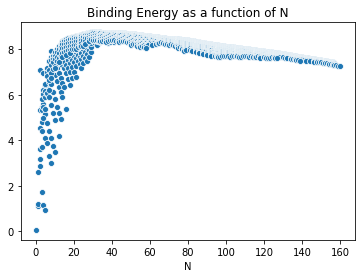

In [14]:
plt.figure(figsize=(6, 4))
sns.scatterplot(df["N"], nn.predict(df[["N", "Z"]])[:, 0])
plt.title("Binding Energy as a function of N")
plt.xlabel("N")
plt.ylabel("")
plt.savefig("Predicted_N.pdf", dpi=1200, bbox_inches="tight")

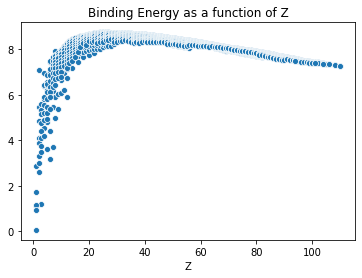

In [15]:
plt.figure(figsize=(6, 4))
sns.scatterplot(df["Z"], nn.predict(df[["N", "Z"]])[:, 0])
plt.title("Binding Energy as a function of Z")
plt.xlabel("Z")
plt.ylabel("")
plt.savefig("Predicted_Z.pdf", dpi=1200, bbox_inches="tight")

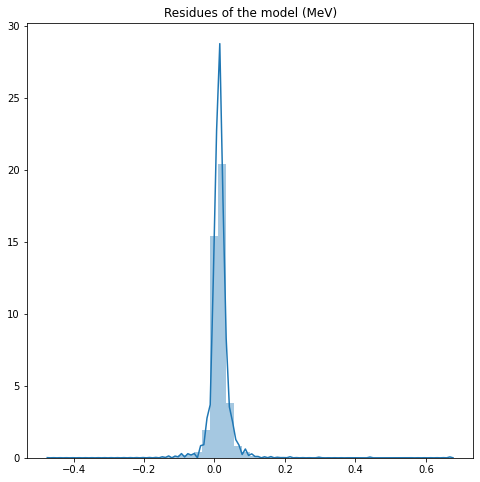

In [16]:
plt.figure(figsize=(8, 8))
sns.distplot(df["BE"]-nn.predict(df[["N", "Z"]])[:, 0])
plt.title("Residues of the model (MeV)")
plt.xlabel("")
plt.ylabel("")
plt.savefig("ResiduesTraining.pdf", dpi=1200, bbox_inches="tight")

Retraining the model also on the validation set (I already assess the quality, now I try to squeeze all the performance I can):

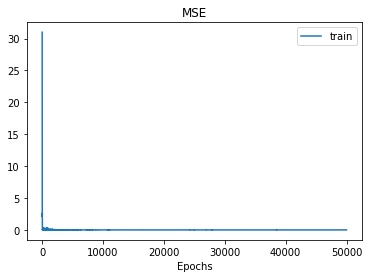

0.001514293795800481


In [17]:
nb_epoch = 50000

nn = Sequential()
nn.add(Dense(32, activation="relu", kernel_initializer="glorot_normal", input_dim=input_dim))
nn.add(Dense(16, activation="relu", kernel_initializer="glorot_normal"))
nn.add(Dense(32, activation="relu", kernel_initializer="glorot_normal"))
nn.add(Dense(8, activation="relu", kernel_initializer="glorot_normal"))
nn.add(Dense(4, activation="relu", kernel_initializer="glorot_normal"))
nn.add(Dense(1, activation="linear", kernel_initializer="glorot_normal"))

nn.compile(optimizer="adam", loss="mean_squared_error")
history = nn.fit(
    X_tr,
    Y_tr,
    epochs=nb_epoch,
    batch_size=batch_size,
    shuffle=True,
    verbose=0,
    validation_split=0.0,
).history

train_loss = history["loss"]
t = np.linspace(1, len(train_loss), len(train_loss))

sns.lineplot(t, train_loss, label="train")
plt.xlabel("Epochs")
plt.title("MSE")
plt.legend() 
plt.show()

print(train_loss[-1])

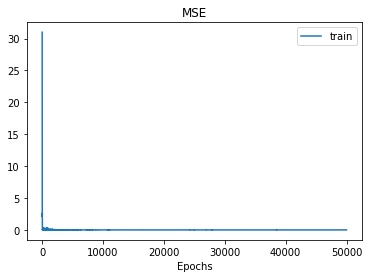

In [18]:
sns.lineplot(t, train_loss, label="train")
plt.xlabel("Epochs")
plt.title("MSE")
plt.legend() 
plt.show()

I save the file following the [machine learning mastering guide](https://machinelearningmastery.com/save-load-keras-deep-learning-models/)

In [19]:
from keras.models import model_from_json


# serialize model to JSON
model_json = nn.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
nn.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# Test set

These data are those present in 2016 but not in 2012 (data from 2012 were the only ones used for training/validation).

In [20]:
test = pd.read_csv("../input/test.csv")
test.head()

,N,Z,BE
0,11,4,4.54097
1,5,10,4.86872
2,6,11,5.49608
3,14,5,4.71963
4,16,7,6.23667


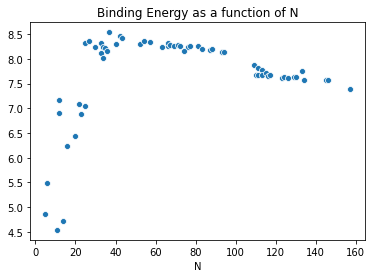

In [21]:
plt.figure(figsize=(6, 4))
sns.scatterplot(test["N"], test["BE"])
plt.title("Binding Energy as a function of N")
plt.xlabel("N")
plt.ylabel("")
plt.savefig("Test_Input_N.pdf", dpi=1200, bbox_inches="tight")

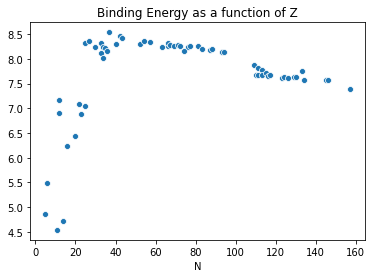

In [22]:
plt.figure(figsize=(6, 4))
sns.scatterplot(test["N"], test["BE"])
plt.title("Binding Energy as a function of Z")
plt.xlabel("N")
plt.ylabel("")
plt.savefig("Test_Input_Z.png", dpi=600, bbox_inches="tight")

In [23]:
Y_test = nn.predict(test[["N", "Z"]])[:, 0]
np.mean((test["BE"]-Y_test)**2)

0.004662537259311759

In [24]:
np.sqrt(np.mean((test["BE"]-Y_test)**2))

0.06828277425025846

# Longer

# Explainability

I consider [the Kaggle course on explainability](https://www.kaggle.com/dansbecker/use-cases-for-model-insights). With two features only, this is not going to bring many insights, but it is easier to follow.

## Permutation importance

> One of the most basic questions we might ask of a model is: What features have the biggest impact on predictions?
This concept is called feature importance. 
There are multiple ways to measure feature importance. Some approaches answer subtly different versions of the question above. Other approaches have documented shortcomings. 

In essence, take the predictions of your model, and a permutation of each feature. Take the difference between the predictions with the feature and the predictions obtained during a random shuffling of the feature. If the reshuffled is better than the original, than the feature is obviously not helping your model.

More on this on the ``eli5`` [document package](https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html?highlight=Permutation%20importance). I have issues with using the module, so I go manually.

In [25]:
np.random.seed(2020)
print("Original score:", np.mean((nn.predict(X_tr)[:, 0] - Y_tr) ** 2))

score_perm = []
for i in range(10):
    X = pd.DataFrame(X_tr).copy()
    X.columns = ["N", "Z"]
    X["N"] = np.random.permutation(X["N"])
    score_perm += [np.mean((nn.predict(X)[:, 0] - Y_tr) ** 2)]
print(score_perm)

print("Permutation score: ", np.mean(score_perm))

Original score: 0.001205626346790387
[10.336497543324302, 9.933321995123045, 10.481970636013473, 9.313198037380623, 9.97677372636529, 10.212502664630243, 9.548995084700893, 9.524191343728061, 9.184865622281633, 9.32775567599317]
Permutation score:  9.784007232954073


Since we need to get the score (MSE) as low as possible and we obtained very high score, the variable ``N`` is very important. Trying for ``Z``:

In [26]:
np.random.seed(2020)
print("Original score:", np.mean((nn.predict(X_tr)[:, 0] - Y_tr) ** 2))

score_perm = []
for i in range(10):
    X = pd.DataFrame(X_tr).copy()
    X.columns = ["N", "Z"]
    X["Z"] = np.random.permutation(X["Z"])
    score_perm += [np.mean((nn.predict(X)[:, 0] - Y_tr) ** 2)]
print(score_perm)

print("Permutation score: ", np.mean(score_perm))

Original score: 0.001205626346790387
[8.690795298390443, 7.9336439994792105, 9.926357036693604, 8.029530715225365, 9.421881943245973, 9.058667960863659, 7.844662664803752, 9.002891041420634, 9.931428726239195, 8.081940186912307]
Permutation score:  8.792179957327413


Thus, also ``Z`` is very important (slightly less, as the worsening of the score is less severe).

## Partial plots

Additional reference [from Medium article](https://towardsdatascience.com/introducing-pdpbox-2aa820afd312) and [online book](https://towardsdatascience.com/introducing-pdpbox-2aa820afd312). Specifically for pdpbox, I [checked the tutorial](https://github.com/SauceCat/PDPbox/blob/master/tutorials/pdpbox_regression.ipynb).

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


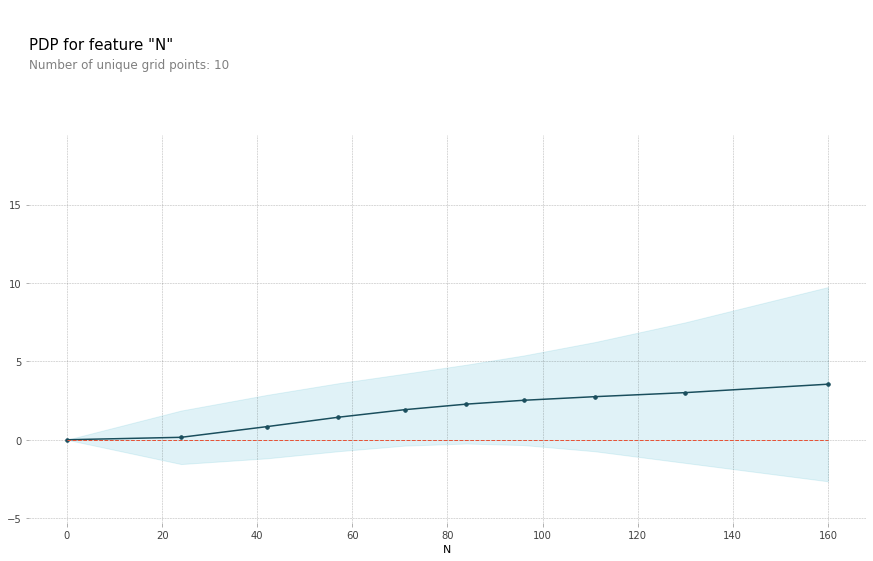

In [27]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots


X_tr = pd.DataFrame(X_tr)
X_tr.columns = ["N", "Z"]

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(
    model=nn, dataset=X_tr, model_features=["N", "Z"], feature="N"
)

# plot it
pdp.pdp_plot(pdp_goals, "N")
plt.show()

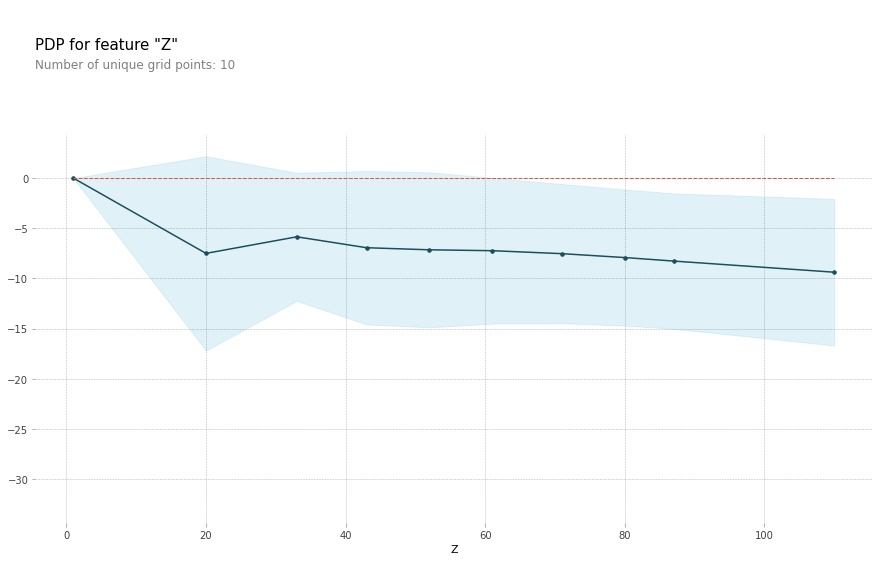

In [28]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(
    model=nn, dataset=X_tr, model_features=["N", "Z"], feature="Z"
)

# plot it
pdp.pdp_plot(pdp_goals, "Z")
plt.show()

Some reference [here](https://christophm.github.io/interpretable-ml-book/pdp.html). The last plot has to be understood like this: with the maximum value for ``Z``, the average prediction for the binding energy (averaging over all the other variables, in this case ``N`` only). The shadowed part is given by the standard deviation. **Verify if it is taking 1 or 2 $\sigma$**

## Shap Values

Reading [the course](https://shap.readthedocs.io/en/latest/) and [the documentation](https://shap.readthedocs.io/en/latest/).

In [29]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.DeepExplainer(nn, X_tr)

# Calculate Shap values
shap_values = explainer.shap_values(X_tr.to_numpy()[:, :])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


* ``expected_value`` is the average (predictions are comparison to the "normal level"). With a scalar values as output (regression), it has dimension 1
* 


In [30]:
shap.initjs()

shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_tr.loc[0, :])

In [31]:
np.argmin(nn.predict(X_tr)[:, 0])

1623

In [32]:
shap.force_plot(explainer.expected_value[0], shap_values[0][1623], X_tr.loc[1623, :])

In [33]:
shap.force_plot(explainer.expected_value[0], shap_values[0][1024], X_tr.loc[1024, :])